<!-- #Imported_libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import random
import pylab
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from matplotlib.cbook import get_sample_data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import Image -->

## Clustering and Classification with Deep Learning on the "FashionMNIST with a Twist!" Dataset

In [2]:
import keras
import numpy as np
import pandas as pd 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

## Preprocessing 

In [3]:
x_train = pd.read_csv('x_train.csv')
x_test= pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

After reading the test and train data for the features and the target, we will go ahead and print their shapes to get a better idea of what they contain

In [4]:
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

y_train: (60000, 1)
y_test: (10000, 1)


The target data gives us a single column with number from 0-4 where each integer representing a mystery class, with 60,000 entries in the training set and 10,000 in the test set. First, let us take a look at how balanced the dataset is. 

In [5]:
y_train_df=pd.DataFrame(y_train)
y_test_df=pd.DataFrame(y_test)
print (pd.value_counts(y_test_df.iloc[:, 0]))
print (pd.value_counts(y_train_df.iloc[:, 0]))

4    3000
2    2000
0    2000
3    2000
1    1000
Name: 0, dtype: int64
4    18000
0    12000
2    12000
3    12000
1     6000
Name: 0, dtype: int64


In total, we have these number of datapoints for each class between the test and train data, and we see the dataset is not perfectly balanced

0: 14,000

1: 7,000

2: 14,000

3: 14,000

4: 21,000

We can carry out one hot encoding to can transform it to 10 columns, with 1 for the index of the class value, using the to_categorical function:

In [6]:
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

Next, we will take a look at the shape of the features

In [7]:
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (60000, 784)
x_test: (10000, 784)


We know the images in this dataset are pre-segmented, and that they all have a grayscale color and square shape of size 28x28. Thus, we will reshape the data arrays to have a single color channel.

In [8]:
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


The new shapes are shown above as 60,000 images in the training dataset and 10,000 in the testing dataset. All of them are 28x28 pixels and have 1 color channel.

Next, we need to attempt to tackle the scaling of the pixel values in the images. Currently, each pixel value is an unsigned integer between 0 and 255 (black to white). To normalize them, we can rescale them to the range 0 to 1. To do so, we can sinmply convert the datatype of the entries to floats, and divide by 255

In [9]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

Finally, let us do a quick plotting of two of the images to see if everything is preprocessed correctly. We will display the first and 4th image (of size 28x28)

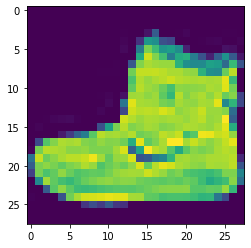

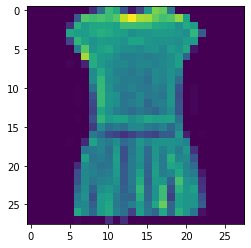

In [10]:
imgtest = x_train[0].reshape((28,28))
plt.imshow(imgtest)
plt.show()
imgtest = x_train[3].reshape((28,28))
plt.imshow(imgtest)
plt.show()

# Classification with Convolutional Neural Networks
## Default Network

For the first Convolutional Nueral Network, we will enter the pre-described setup from the assignment which is: 

CNN Layer 1 $\Rightarrow$ Max-Pooling Layer $\Rightarrow$ CNN Layer 2 $\Rightarrow$ Dense Softmax output layer

Both CNN Layers have the the parameters of kernal size 3x3, 32 filters, stride 1, padding (1,1). We also added flattening before the output layer to 5 outputs, otherwise the shape would be incompatible. The flattening will 'unroll'the 3D output to 1D

In [11]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), activation='relu', 
                  input_shape=(28, 28, 1),
                  strides=(1, 1),padding='same'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(32, (3, 3), activation='relu',
                  strides=(1, 1),padding='same'))
model1.add(Flatten())
model1.add(Dense(5, activation='softmax'))
model1.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

## Results Analysis for Default Network

Now, we take this default model that was created and fit it to the training set, after extracting a validation set of 20% of the size. 

The Epoch parameter defines the number of times that the learning algorithm works through the entire dataset. Although the algorithm generally would work more accurately as you increase the number of iterations, the computational time also increases significantly, and after a number of Epochs, the small increase in accuracy is not worth the extra computational effort anymore. It also reduces the model's ability to generalize. Upon trying 20,15 and 15 Epochs, a middle ground of 10 Epochs was chosen, and the model summary is printed:

In [12]:
model1_fit = model1.fit(x_train, y_train, 
                        validation_split=0.2, batch_size=128,epochs=15)
model1.summary()

Epoch 1/15
375/375 [==============================] - 32s 82ms/step - loss: 0.4448 - accuracy: 0.8321 - val_loss: 0.3188 - val_accuracy: 0.8855
Epoch 2/15
375/375 [==============================] - 30s 80ms/step - loss: 0.2928 - accuracy: 0.8958 - val_loss: 0.2674 - val_accuracy: 0.9046
Epoch 3/15
375/375 [==============================] - 30s 81ms/step - loss: 0.2510 - accuracy: 0.9102 - val_loss: 0.2527 - val_accuracy: 0.9093
Epoch 4/15
375/375 [==============================] - 30s 81ms/step - loss: 0.2252 - accuracy: 0.9199 - val_loss: 0.2270 - val_accuracy: 0.9205
Epoch 5/15
375/375 [==============================] - 30s 81ms/step - loss: 0.2051 - accuracy: 0.9262 - val_loss: 0.2166 - val_accuracy: 0.9232
Epoch 6/15
375/375 [==============================] - 30s 81ms/step - loss: 0.1923 - accuracy: 0.9323 - val_loss: 0.2169 - val_accuracy: 0.9245
Epoch 7/15
375/375 [==============================] - 30s 80ms/step - loss: 0.1790 - accuracy: 0.9362 - val_loss: 0.2004 - val_accuracy:

From the above summary, we can see the output of every Conv2D and the MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions seem to shrink as we go deeper in the network, and that is typically why we can computationally afford to add more output channels in each Conv2D layer. We can also see how the Flattening Layer changed the 3D shape to a one dimensional array before going into the final dense layer. 

For each Epoch, the training and validation loss and accuracy are printed. At first, the accuracy increases rapidly, but the increase starts to slow down as we approach the final Epoch, giving us final numbers of:

Loss: 11.66%

**Accuracy: 95.88%**

Validation Loss: 18.65%

Validation Accuracy: 93.73%

Now, let us do the real test of checking the accuracy and loss of the model on our test data which the model has not yet seen before.

In [13]:
loss, accuracy = model1.evaluate(x_test,y_test)
print(loss, accuracy)

313/313 [==============================] - 4s 11ms/step - loss: 0.2097 - accuracy: 0.9285
0.20973220467567444 0.9284999966621399


The accuracy on the test set with this default model gives us an accuracy of **92.85%** and a loss of 20.97%

Now, to visualize the trends over the Epochs, we can plot the Classification Accuracy and Loss for both the training and validation set.

Another useful visualization is to plot the loss of the train and validation set in one graph, and do the same for the accuracy.

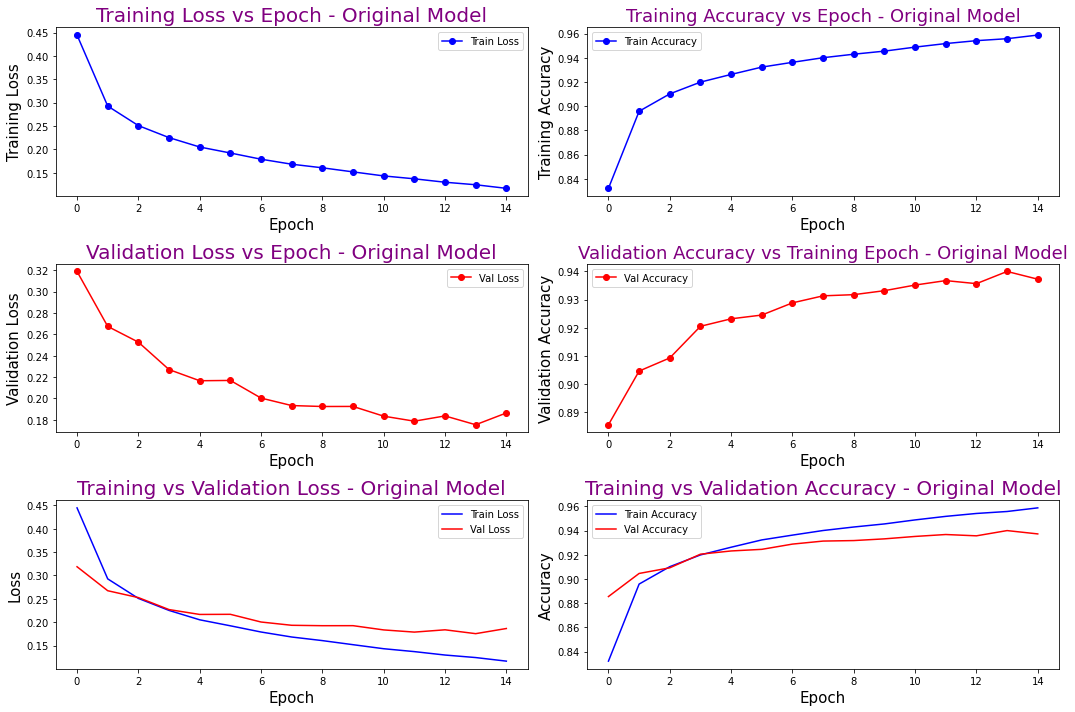

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
plt.title('Training Loss vs Epoch - Original Model',fontsize=20,color='purple')
plt.plot(model1_fit.history['loss'], label='Train Loss', color='blue',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Training Loss',fontsize=15)
plt.legend()
plt.subplot(3,2,2)
plt.title('Training Accuracy vs Epoch - Original Model',fontsize=18,color='purple')
plt.plot(model1_fit.history['accuracy'], label='Train Accuracy', color='blue',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Training Accuracy',fontsize=15)
plt.legend()

plt.subplot(3,2,3)
plt.title('Validation Loss vs Epoch - Original Model',fontsize=20,color='purple')
plt.plot(model1_fit.history['val_loss'], label='Val Loss', color='red',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Validation Loss',fontsize=15)
plt.legend()
plt.subplot(3,2,4)
plt.title('Validation Accuracy vs Training Epoch - Original Model',fontsize=18,color='purple')
plt.plot(model1_fit.history['val_accuracy'], label='Val Accuracy', color='red',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.legend()

plt.subplot(3,2,5)
plt.title('Training vs Validation Loss - Original Model',fontsize=20,color='purple')
plt.plot(model1_fit.history['loss'], label='Train Loss', color='blue')
plt.plot(model1_fit.history['val_loss'], label='Val Loss', color='red')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.legend()

plt.subplot(3,2,6)
plt.title('Training vs Validation Accuracy - Original Model',fontsize=20,color='purple')
plt.plot(model1_fit.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(model1_fit.history['val_accuracy'], label='Val Accuracy', color='red')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()

plt.tight_layout()

The shape of the loss vs epoch curves above show us that the learning rate was not so good, for both the train and validation sets. Numerically, the loss in the training set started higher than the validation set but tapered off to about the same amount, with the validation loss being a bit higher.

The shape of the accuracy vs epoch graphs show us that accuracy increased rapidly in both cases at the start but eventually began to taper off, indicating that the cost of adding epochs would not have been worth the small increase in accuracy. 

A very important graph is te last one, which shows the training and validation accuracy in one graph. The gap between the two as the graph tapers off shows us that the model has a little overfit, since the training accuracy was higher than the validation accuracy.

## Your Own Network

Now, we will make some changes to the default CNN model in this assignment by modifying some  and adding some layers. 

The new sequence of layers will be:


CNN Layer 1 with 32 filters $\Rightarrow$ CNN Layer 2 with 128 filters $\Rightarrow$ Max-Pooling Layer $\Rightarrow$ Batch Normalization $\Rightarrow$ Dropout $\Rightarrow$CNN Layer 3 with 64 filters $\Rightarrow$ Pooling Layer $\Rightarrow$ Batch Normalization $\Rightarrow$ Dropout $\Rightarrow$ Flatterning Layer $\Rightarrow$ CNN Dense Layer 1 $\Rightarrow$ CNN  Dense Softmax output layer 2

The compiler will be kept the Adam Optimizer as in the default model since it is one of the most commonly used, high performing and computationally efficient optimizers for this application



In [15]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), activation='relu', 
                  input_shape=(28, 28, 1),strides=(1, 1),padding='same'))
model2.add(Conv2D(128, (3,3), activation='relu', 
                  input_shape=(28, 28, 1),strides=(1,1)))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))  

model2.add(Conv2D(64, (3, 3), activation='relu',strides=(1,1),padding='same'))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))  

model2.add(Flatten())

model2.add(Dense(64, activation='relu'))   
model2.add(Dense(5, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', 
               metrics=['accuracy'])

From the above modifications, the justifications for each are as follows:

* **Added More Conv2D Layers**: Adding more convolutional layers provides us with a hierarchical decomposition of the input. The filters operating directly on the raw pixel (the first Conv2D layer) learns to extract low level features (for example, lines). The next one can go onto extract more 'complicated' features like complete shapes. As we go down the stack of layers, the layers start to learn more complex features. Together, the combination of all the layers can learn features at various levels of abstraction, and lead to a better and much more accurate model.

* **Increased Number of Filters**: As mentioned above, each Conv2D layer starts learning more complex patterns as we go deeper into the network. As a result, it is theoretically expected to increase the filter size of each layer to capture as many combinations as possible, and extract as many abstractions from the image. In this case, we increase it from 32 abrubtly to 128 in the start of the model. We do decrease it down to 64, and do not want to increase it much more as that would give us a risk of overfitting.

* **Batch Normalization**: This is a great contributor to the enhancement from the default model as it standardizes the inputs to a layer for each mini-batch by normalizing the weights on each layer. This in turn, stabilizes the learning process and dramatically reduces the number of training epochs required to train deep networks.

* **Added Dropout**: Although this is not incredibly necessary thanks to the batch normalization, the dropout method provided an increase to the accuracy from the default model by reguralizing the model simply and effectively by means of probabilistically dropping out nodes in the network. It also reduces risk of overfitting. In terms of placement, it is best to put it after the Batch Normalization

* **Added another Dense Layer**: We included an additional dense layer (with ReLU) prior to the final softmax output layer, because unlike the Conv2D layer, the fully connected layer learns features from all the combinations of the features of the previous layer, whereas a convolutional layer relies on local spatial coherence with a small receptive field. But since dense layers are so computationally expensive, we will not add too many to enhance our model.

A few things that were *not* altered in attempt to improve the model includes the **Stride** which just controls how many units the filter shifts as it colvolves around the inputted volume. By keeping this parameter in our model, we can reduce spatial resolution, leading to computational benefits and reduction of overlap of receptive fields, but no particular increase in accuracy is obtained. We will also keep the **Relu Units** as the activation layer, which provides a nonlinearity to the system, and works best in place of other activation layers thanks to its fast training and computational efficiency without the cost of losing accuracy. The **MaxPooling** layer is also kept because it reduces the weights and also is a factor in keeping the risk of overfitting low. 

## Results Analysis for Custom Network

Now that we have designed our custom model, we will go ahead and fit it to the train and validation set below and obtain the model summary, again with 15 Epochs. 

In [16]:
model2_fit = model2.fit(x_train, y_train, 
                        validation_split=0.2, batch_size=128,epochs=15)
model2.summary()

Epoch 1/15
375/375 [==============================] - 977s 3s/step - loss: 0.4201 - accuracy: 0.8417 - val_loss: 1.3668 - val_accuracy: 0.3082
Epoch 2/15
375/375 [==============================] - 279s 745ms/step - loss: 0.2566 - accuracy: 0.9055 - val_loss: 0.2262 - val_accuracy: 0.9166
Epoch 3/15
375/375 [==============================] - 103s 276ms/step - loss: 0.2160 - accuracy: 0.9218 - val_loss: 0.1829 - val_accuracy: 0.9356
Epoch 4/15
375/375 [==============================] - 78s 207ms/step - loss: 0.1938 - accuracy: 0.9283 - val_loss: 0.1864 - val_accuracy: 0.9309
Epoch 5/15
375/375 [==============================] - 80s 214ms/step - loss: 0.1767 - accuracy: 0.9359 - val_loss: 0.1832 - val_accuracy: 0.9348
Epoch 6/15
375/375 [==============================] - 85s 226ms/step - loss: 0.1630 - accuracy: 0.9408 - val_loss: 0.1790 - val_accuracy: 0.9358
Epoch 7/15
375/375 [==============================] - 86s 230ms/step - loss: 0.1551 - accuracy: 0.9429 - val_loss: 0.1670 - val_ac

From the above summary, we can see the output of every Conv2D and the MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions seem to shrink as we go deeper in the network, and that is typically why we can computationally afford to add more output channels in each Conv2D layer. We see how Maxpooling reduces the height and width, while batch normalization and dropout do not have an affect on the shape. We can also see how the Flattening Layer changed the 3D shape to a one dimensional array before going into the final 2 dense layers.

For each Epoch, the training and validation loss and accuracy are printed, as well as the loss. At first, the accuracy increases rapidly, but the increase starts to slow down as we approach the final Epoch, giving us final numbers of:

Loss: 11.24%

Accuracy: 95.84%

Validation Loss: 15.10%

Validation Accuracy: 94.80%

Now, let us do the real test of checking the accuracy and loss of the model on our test data which the model has not yet seen before.

In [17]:
loss, accuracy = model2.evaluate(x_test,y_test)
print(loss, accuracy)

313/313 [==============================] - 8s 26ms/step - loss: 0.1614 - accuracy: 0.9448
0.16135326027870178 0.9448000192642212


The accuracy on the test set with this custom model gives us an accuracy of **94.48%** and a loss of 16.14%

This is a two percent increase from the original model. Although this is not a dramatic difference in accuracy or loss values, many added features in this model make for a better network, such as the Batch Normalization, Dropout Layers, and adding more Conv2D and Dense Layers. We can see further differences when we visualize the trends.

To visualize the trends over the Epochs, we can plot the Training Loss vs Epoch, Validation Loss vs Epoch, and a graph with both in one plot:

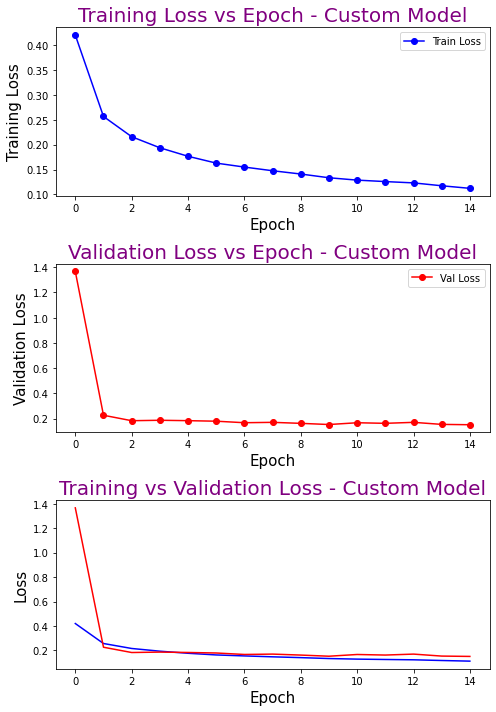

In [18]:
plt.figure(figsize=(7,10))

plt.subplot(3,1,1)
plt.title('Training Loss vs Epoch - Custom Model',fontsize=20,color='purple')
plt.plot(model2_fit.history['loss'], label='Train Loss', color='blue',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Training Loss',fontsize=15)
plt.legend()
plt.subplot(3,1,2)

plt.title('Validation Loss vs Epoch - Custom Model',fontsize=20,color='purple')
plt.plot(model2_fit.history['val_loss'], label='Val Loss', color='red',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Validation Loss',fontsize=15)
plt.legend()

plt.subplot(3,1,3)
plt.title('Training vs Validation Loss - Custom Model',fontsize=20,color='purple')
plt.plot(model2_fit.history['loss'], label='Train Loss', color='blue')
plt.plot(model2_fit.history['val_loss'], label='Val Loss', color='red')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)

plt.tight_layout()

The shape of the loss vs epoch curves above show us that the learning rate was great for both the train and validation sets.

Now, let us compare the loss graphs of this custom model to that of the original model to see if we can observe any improvements from the adjustments we made. We will plot the validation and training loss of both models in one graph (blue for the default model, and red for our own model)

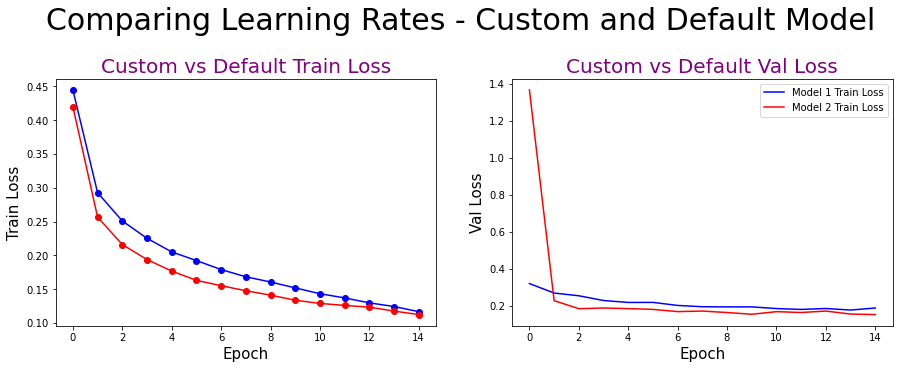

In [19]:
plt.figure(figsize=(15,10))
#comparing learning rates
plt.suptitle('Comparing Learning Rates - Custom and Default Model',fontsize=30)
plt.subplot(2,2,1)
plt.title('Custom vs Default Train Loss',fontsize=20,color='purple')
plt.plot(model1_fit.history['loss'], label='Model 1 Train Loss', color='blue',marker="o")
plt.plot(model2_fit.history['loss'], label='Model 2 Train Loss', color='red',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Train Loss',fontsize=15)

plt.subplot(2,2,2)
plt.title('Custom vs Default Val Loss',fontsize=20,color='purple')
plt.plot(model1_fit.history['val_loss'], label='Model 1 Train Loss', color='blue')
plt.plot(model2_fit.history['val_loss'], label='Model 2 Train Loss', color='red')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Val Loss',fontsize=15)
plt.legend()

When comparing to the default model, our custom model indicates a better learning rate. With low learning rates (more like the default model), the improvements will be linear. With high learning rates (more like our own model) they will start to look more exponential/curved. 

Now, let us plot the Accuracy for both the training and validation set of our custom model.

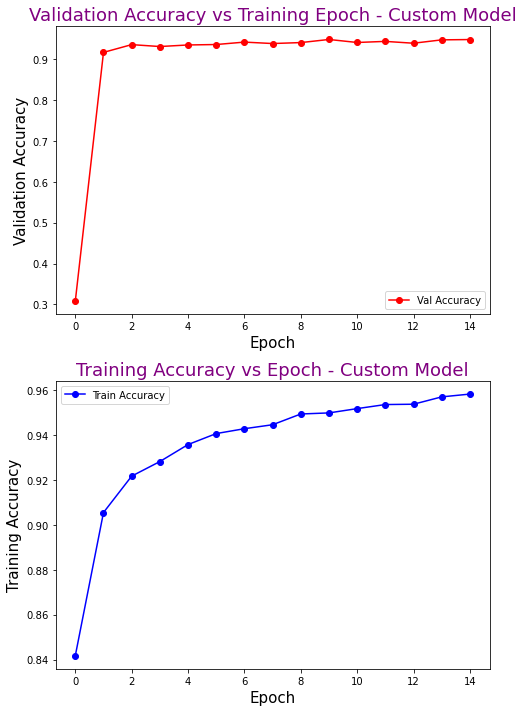

In [20]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.title('Validation Accuracy vs Training Epoch - Custom Model',fontsize=18,color='purple')
plt.plot(model2_fit.history['val_accuracy'], label='Val Accuracy', color='red',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.legend()

plt.subplot(2,1,2)
plt.title('Training Accuracy vs Epoch - Custom Model',fontsize=18,color='purple')
plt.plot(model2_fit.history['accuracy'], label='Train Accuracy', color='blue',marker="o")
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Training Accuracy',fontsize=15)
plt.legend()

plt.tight_layout()

The shape of the accuracy vs epoch graphs show us that accuracy increased rapidly in both cases at the start but eventually began to taper off, indicating that the cost of adding epochs would not have been worth the small increase in accuracy. The validation accuracy shape seems to be more horizontal as it tapers off, but let us also plot a graph with both of them into one plot to view the gap between them:



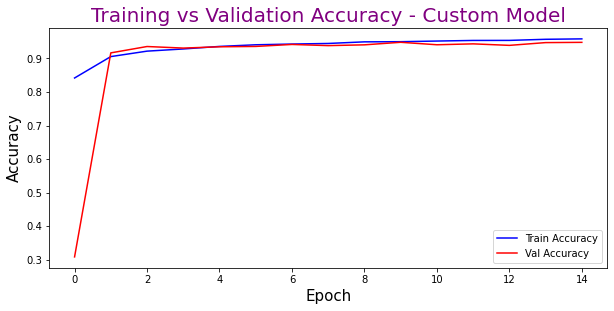

In [21]:
plt.figure(figsize=(10,15))

plt.subplot(3,1,3)
plt.title('Training vs Validation Accuracy - Custom Model',fontsize=20,color='purple')
plt.plot(model2_fit.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(model2_fit.history['val_accuracy'], label='Val Accuracy', color='red')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()

The gap between the training and validation accuracy is very miniscule, and that indicates a positive sign of almost no overfitting. Let us compare this gap to that of our default model (default model colors in blue, and our custom model colors in red)

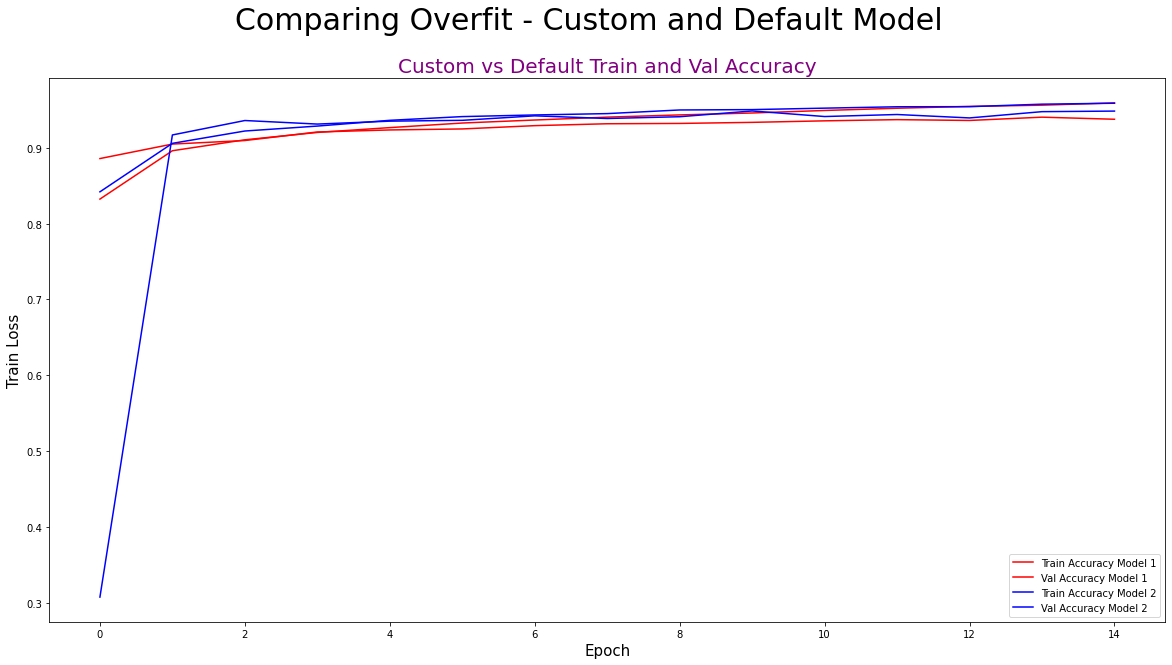

In [22]:
plt.figure(figsize=(20,10))
plt.suptitle('Comparing Overfit - Custom and Default Model',fontsize=30)

plt.subplot(1,1,1)
plt.title('Custom vs Default Train and Val Accuracy',
          fontsize=20,color='purple')
plt.plot(model1_fit.history['accuracy'], 
         label='Train Accuracy Model 1', color='red')
plt.plot(model1_fit.history['val_accuracy'], 
         label='Val Accuracy Model 1', color='red')
plt.plot(model2_fit.history['accuracy'], 
         label='Train Accuracy Model 2', color='blue')
plt.plot(model2_fit.history['val_accuracy'], 
         label='Val Accuracy Model 2', color='blue')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Train Loss',fontsize=15)
plt.legend()

We can see easily from the above plot that the gap between the training and validation accuracy in the custom model is significantly smaller than the default model, which again is an indication that the improvements made in the custom setup led to a better model

## Using Your Own Encoding

Prior to carrying out the required clustering and visualization techniques, we will extract a layer from the custom model to be carried forward and used. First let us take a look at our layers again. 

In [23]:
layer_names=[layer.name for layer in model2.layers]
layer_outputs=[layer.output for layer in model2.layers[:-1]]
print(layer_names)

['conv2d_2', 'conv2d_3', 'max_pooling2d_1', 'batch_normalization', 'dropout', 'conv2d_4', 'max_pooling2d_2', 'batch_normalization_1', 'dropout_1', 'flatten_1', 'dense_1', 'dense_2']


From these layers, we will use the the Fully Connected Dense Layer output that we obtained after the last flattening in our custom model. We create a new model with this layer, and normalize it so it is ready for use for many different classifiers

In [24]:
new_model=tf.keras.Model(inputs=model2.input,
                         outputs=layer_outputs)
intermediateOutputs=new_model.predict(x_test)
cnn_layer=intermediateOutputs[-2]  
scalar=StandardScaler(copy=False)
scaled_cnn_layer=cnn_layer.copy()
scalar.fit_transform(scaled_cnn_layer)
scaled_cnn_layer.shape

(10000, 2304)

**Visualize your encoding with the first two components from PCA, the colour mapping could
be the label values.** 

We start by using that flattened layer to visualize our encoding on a 2D PCA classification.

In [27]:
pca=PCA(n_components=2)
PCs=pca.fit_transform(scaled_cnn_layer)
column_names=["PCA1","PCA2"]
PCA_DataFrame=pd.DataFrame(data=PCs,columns=column_names)
PCA_DataFrame

,PCA1,PCA2
0,27.552649,-7.489489
1,-15.089963,-11.436487
2,-1.228686,34.533833
3,-0.687337,34.122364
4,-13.483702,-9.865523
...,...,...
9995,20.605167,-12.823506
9996,1.259447,26.752663
9997,0.273997,3.733207
9998,-0.073571,31.578238


Now let us concatenate the target column to this PCA DataFrame

In [28]:
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
Target_DataFrame=pd.DataFrame(y_test)
finalPCA=pd.concat([PCA_DataFrame,Target_DataFrame],axis=1)
finalPCA=finalPCA.rename(columns={'0':'Target'})
finalPCA

,PCA1,PCA2,Target
0,27.552649,-7.489489,4
1,-15.089963,-11.436487,2
2,-1.228686,34.533833,2
3,-0.687337,34.122364,2
4,-13.483702,-9.865523,0
...,...,...,...
9995,20.605167,-12.823506,4
9996,1.259447,26.752663,2
9997,0.273997,3.733207,3
9998,-0.073571,31.578238,2


Now, we will plot this PCA graph to properly visualize the encoding, with the color mapping as our label values (which have a value of 0,1,2,3 or 4)

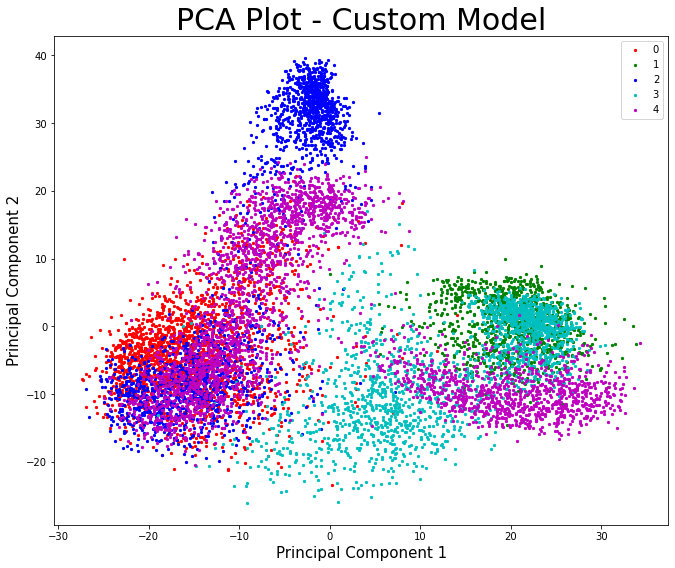

In [29]:
figure = plt.figure(figsize = (11,9))
ax = figure.add_subplot(1,1,1)
ax.set_title('PCA Plot - Custom Model',fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 1', fontsize = 15)
targets=[0,1,2,3,4]
colors = ['r','g','b','c','m']
for target, color in zip(targets, colors):
    indicesTokeep = finalPCA['Target'] == target
    ax.scatter(finalPCA.loc[indicesTokeep, 'PCA1'] , 
               finalPCA.loc[indicesTokeep, 'PCA2'],
               c = color,s=5,label=target)
ax.legend()

The plot above shows us the 5 classes in different colors clustered together. We keep in mind a very large number of features has been reduced to only two, so some data must have been lost along the way. From the plot, we can see a lot of the colors overlapping each other, although the same color groups are generally clumped together. 

**Perform DBSCAN and K-means clustering algorithms on the features that you have ex-
tracted from your own designed model with 5 clusters and visualize the results. Use the
resulting clusters as alternate colour mappings for the PCA plot above.**

First, we perform DBSCAN, fitting it to our extracted CNN Layer.  

DBSCAN, standing for Density-Based Spatial Clustering of Applications with Noise, is an unsupervised algorithm (unlike the PCA analysis we just did). We are not able to select the number of clusters in a DBSCAN analysis, but we can adjust the following parameters and try to tune them to get the desired number of clusters:

* **Eps:** The maximum distance between two samples for one to be considered as in the neighborhood of the other

* **Min_Samples:** The minumum number of samples in a neighborhood to be considered a core point

It is possible to find a suitable value for eps by calculating the distance to the nearest n points for each point (using the Nearest Neighbours algorithm). We can sort and plot the results and analyze the graph to see where the change is most pronounced. That gives us a good epsilon for that number of minimum samples. 



<Figure size 720x720 with 0 Axes>

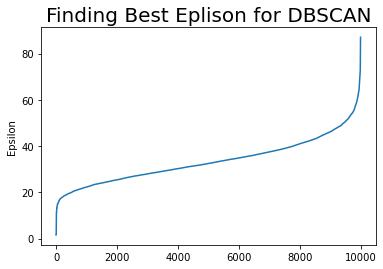

<Figure size 720x720 with 0 Axes>

In [30]:
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(scaled_cnn_layer) 
distances, indices = neighbors_fit.kneighbors(scaled_cnn_layer) 
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylabel('Epsilon')
plt.title('Finding Best Eplison for DBSCAN',fontsize=20)
plt.figure(figsize=(10,10))

The plot above shows us two 'elbow' points; one at epsilon = 20, and one at 45. Upon trying them both, we saw the best results were recieved by choosing epsilon = 45, for the minimum number of 15 samples. 

We can use these parameters in our DBSCAN Algorithm:

In [31]:
dbscan = DBSCAN(eps=45, min_samples=15) 
clusters=dbscan.fit_predict(scaled_cnn_layer)  
DBScanLabels=dbscan.labels_
temp=pd.DataFrame(DBScanLabels)

print(pd.value_counts(temp[0]))

 0    8218
-1    1655
 2      58
 1      57
 3      12
Name: 0, dtype: int64


Although we were attempting to form 5 clusters (to compare to the PCA plot), the best graph that was found was with 4 clusters of class labels 0,1,2,3 and a 5th 'class' for the noise points. We can see from the members of the classes above that the classification was very unbalanced as a majority of the points were put into one class, and the second majority of points were set to be noise. And the remaining 3 classes have a miniscule number of members but DBSCAN still classified them into their own clusters. 

Now, we will plot this DBSCAN algorithm on the PCA dimensions we extracted earlier.

Text(0.5, 0, 'Principal Component 1')

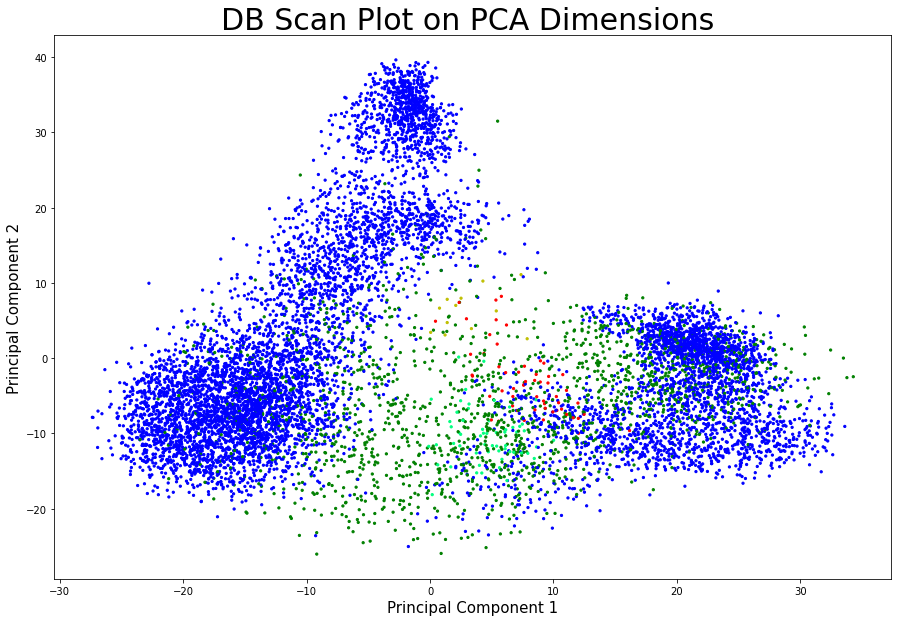

In [32]:
figure = plt.figure(figsize = (15,10))
ax = figure.add_subplot(1,1,1)
colormap = np.array(['b','r','springgreen','y','m','g'])
ax.scatter(finalPCA['PCA1'], finalPCA['PCA2'], 
           c = colormap[clusters],s=5) # plotting the clusters
ax.set_title('DB Scan Plot on PCA Dimensions ',fontsize=30)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 1', fontsize = 15)

The DBSCAN plot above shows how the algorithm classified points of similar density (blue points) as one class, and labelled the rest (green) as noise. There are a few points here are there (red) which are classified into other classes. The reason why DBSCAN may not be doing a good job of classifying true clusters is because they have varying densities, and the way this algorithm works is simply forming clusters of dense regions of data points. It just ignores the lower density points and treats them as noise, although in reality they might be important points which should have been assigned to a class.

Now, we will repeat the analysis with **KMeans Clustering**, using the same scaled flattened layer from our custom CNN design

KMeans is another unsupervised learning algorithm, where the number of clusters can be predefined. The algorithm starts with a group of randomly selected central points, evaluates distances to its neighbours, and iteratively calculates to optimize the points which should be kept as the centers. In this case, we choose the number of clusters to be 5:

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
clusters2=kmeans.fit_predict(scaled_cnn_layer)
KMeansLabels=kmeans.labels_
temp2=pd.DataFrame(KMeansLabels)
temp2[0].unique()
pd.value_counts(temp2[0])

1    4023
3    1984
4    1635
2    1392
0     966
Name: 0, dtype: int64

We can see the data is much more balanced in the classification this time. We will plot it on the PCA dimensions to visualize the clusters

Text(0.5, 0, 'Principal Component 1')

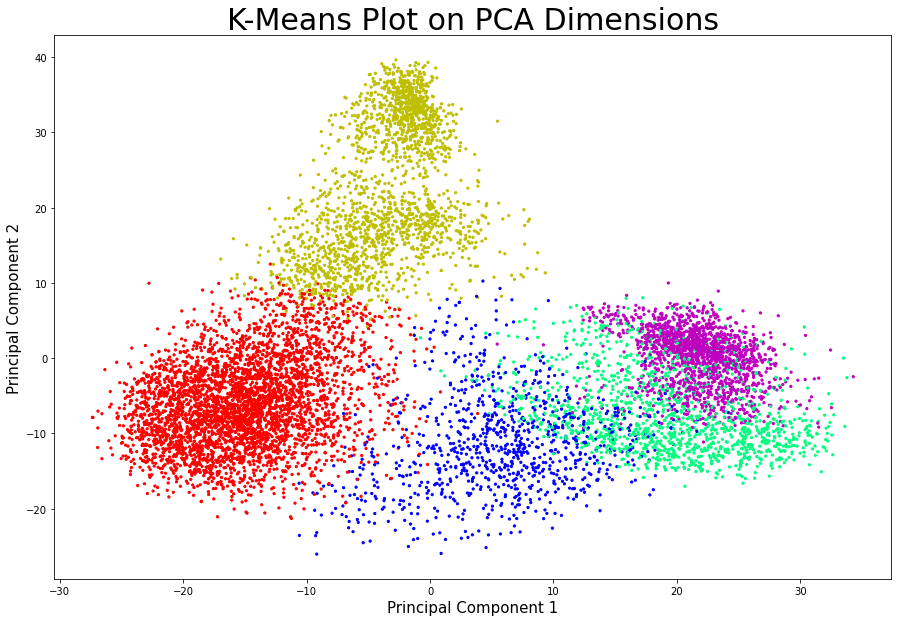

In [34]:
figure = plt.figure(figsize = (15,10))
ax = figure.add_subplot(1,1,1)
colormap = np.array(['b','r','springgreen','y','m','g'])
ax.scatter(finalPCA['PCA1'], finalPCA['PCA2'],
           c = colormap[clusters2],s=5) # plotting the clusters
ax.set_title('K-Means Plot on PCA Dimensions',fontsize=30)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 1', fontsize = 15)

The K-Means graph above seems to show us a better clustering than the DBSCAN, since it was not affected by varying densities of the datapoints. However, K-Means does not work well with outliers and noisy data, which may be a disadvantage to this model.

**Apply t-SNE on the features that you have extracted for your own designed model and
visualize the results in the same way.**

Now, we will use the same layer that we used for the PCA, but this time use TSNE to reduce the data to 2 dimensions. 

In [35]:
tsne=TSNE(n_components=2)
TSNEs=tsne.fit_transform(scaled_cnn_layer)
column_names=["TSNE1","TSNE2"]
TSNE_DataFrame=pd.DataFrame(data=TSNEs,
                            columns=column_names)
TSNE_DataFrame

,TSNE1,TSNE2
0,-40.267052,11.569246
1,-10.435102,62.158512
2,28.398623,-78.515671
3,12.367999,-72.420692
4,-3.113471,26.126036
...,...,...
9995,-50.377342,19.679115
9996,7.184357,-50.247013
9997,8.336113,-18.132994
9998,1.138766,-60.999485


We will add on the target to the DataFrame

In [36]:
finalTSNE=pd.concat([TSNE_DataFrame,Target_DataFrame],axis=1)
finalTSNE=finalTSNE.rename(columns={'0':'Target'})
finalTSNE

,TSNE1,TSNE2,Target
0,-40.267052,11.569246,4
1,-10.435102,62.158512,2
2,28.398623,-78.515671,2
3,12.367999,-72.420692,2
4,-3.113471,26.126036,0
...,...,...,...
9995,-50.377342,19.679115,4
9996,7.184357,-50.247013,2
9997,8.336113,-18.132994,3
9998,1.138766,-60.999485,2


Now, we visualize this TSNE Plot 

array([2, 1, 3, ..., 0, 3, 4])

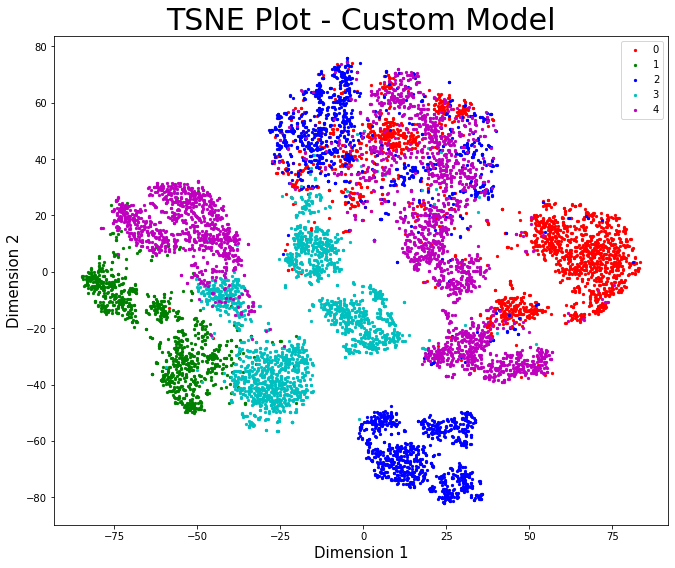

In [42]:
figure = plt.figure(figsize = (11,9))
ax = figure.add_subplot(1,1,1)
ax.set_title('TSNE Plot - Custom Model',fontsize = 30)
ax.set_ylabel('Dimension 2', fontsize = 15)
ax.set_xlabel('Dimension 1', fontsize = 15)
targets=[0,1,2,3,4]
colors = ['r','g','b','c','m']
for target, color in zip(targets, colors):
    indicesTokeep = finalTSNE['Target'] == target
    ax.scatter(finalTSNE.loc[indicesTokeep, 'TSNE1'] , 
               finalTSNE.loc[indicesTokeep, 'TSNE2'],
               c = color,s=5,label=target)
ax.legend()


The TSNE plot created several clusters of data where points that were close in high dimensions were kept close in this low dimension representation. 

We keep in mind the following points about TSNE before proceeding

* We cannot see the relative sizes of clusters in a TSNE Plot

* Distances between well-separated clusters in a TSNE plot may mean nothing

* Clumps of points might just be noise in a TSNE Plot.

**Perform DBSCAN and K-means clustering algorithms on the features that you have ex- tracted from your own designed model with 5 clusters and visualize the results. Use the resulting clusters as alternate colour mappings for the TSNE plot above.**

First, we take the same DBSCAN model that we fit to our extracted CNN Layer, and plot it on the TSNE dimensions. 

Text(0.5, 0, 'Dimension 1')

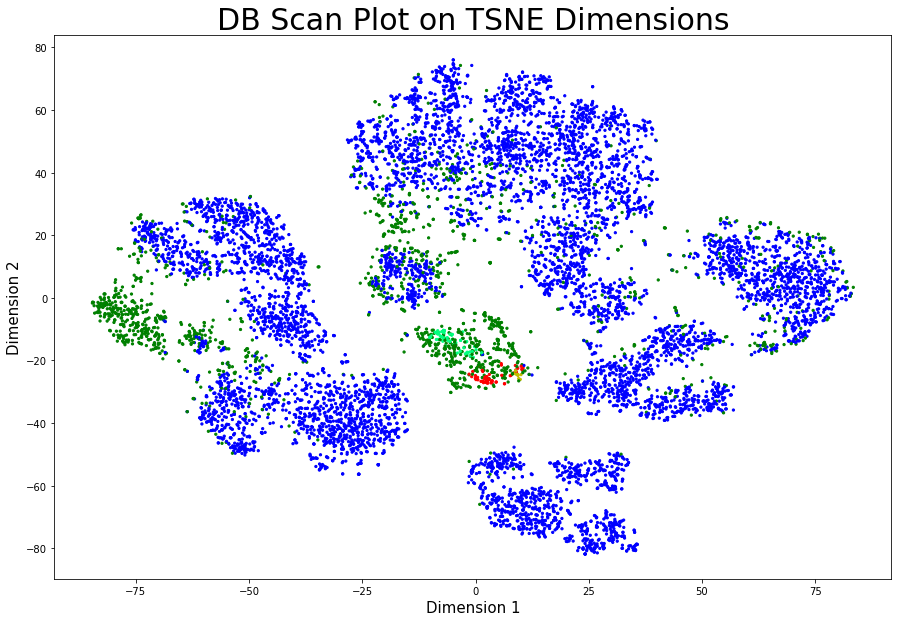

In [38]:
figure = plt.figure(figsize = (15,10))
ax = figure.add_subplot(1,1,1)
colormap = np.array(['b','r','springgreen','y','m','g'])
ax.scatter(finalTSNE['TSNE1'], finalTSNE['TSNE2'],
           c = colormap[clusters],s=5) 
ax.set_title('DB Scan Plot on TSNE Dimensions',fontsize=30)
ax.set_ylabel('Dimension 2', fontsize = 15)
ax.set_xlabel('Dimension 1', fontsize = 15)

The DBSCAN plot above again shows how the algorithm classified points of similar density (blue points) as one class, and labelled the rest (green) as noise. There are a few points here are there (red) which are classified into other classes.

Now, we will take the K-Means model that was fit on the CNN Layer earlier, and plot it on the TSNE dimensions.

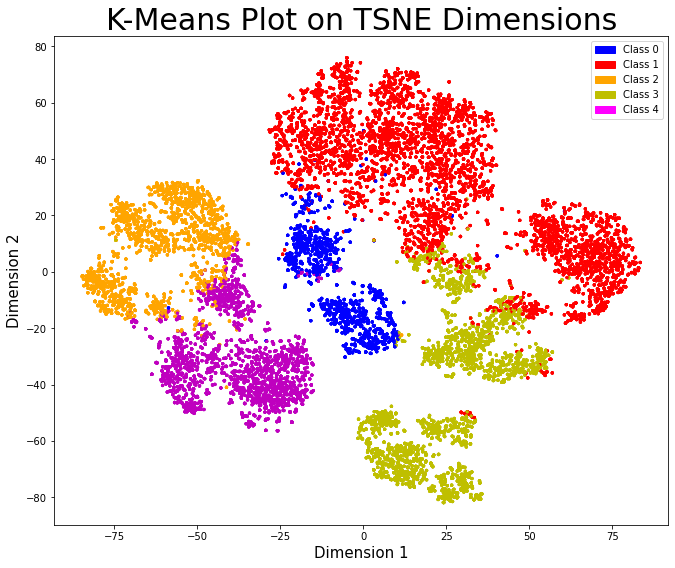

In [80]:
import matplotlib.patches as mpatches
figure = plt.figure(figsize = (11,9))
ax = figure.add_subplot(1,1,1)
blue_patch = mpatches.Patch(color='blue', label='Class 0')
red_patch = mpatches.Patch(color='red', label='Class 1')
orange_patch = mpatches.Patch(color='orange', label='Class 2')
yellow_patch = mpatches.Patch(color='y', label='Class 3')
magenta_patch = mpatches.Patch(color='magenta', label='Class 4')
ax.set_title('K-Means Plot on TSNE Dimensions',fontsize = 30)
ax.set_ylabel('Dimension 2', fontsize = 15)
ax.set_xlabel('Dimension 1', fontsize = 15)
targets=[0,1,2,3,4]
colormap = np.array(['b','r','orange','y','m','g'])
for target, color in zip(targets, colors):
    indicesTokeep = finalTSNE['Target'] == target
    ax.scatter(finalTSNE['TSNE1'] , 
               finalTSNE['TSNE2'],
              c = colormap[clusters2],s=5)
ax.legend(handles=[blue_patch,red_patch,orange_patch,yellow_patch,magenta_patch])

The K-means plot above shows us the 5 clusters it classified using the distance between points as a measure of similarity. 

**Based on the results of clustering and t-SNE can you guess what are the labels for the
given dataset? It might also help to list out a random selection of data entries (the original
images) for each cluster and their label value to help understand the patterns each cluster
might represent.**

In order to get a better idea of what the clusters contain, we will take one of our clustering algorithms (the K-Means clusters) and plot the resulting images. 

Class label: 0


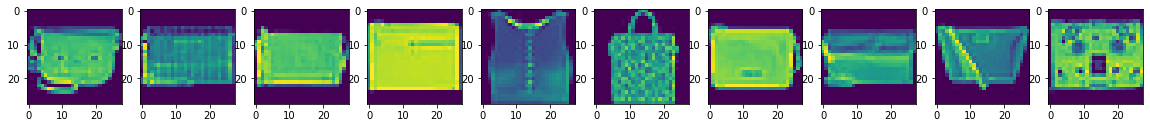

Class label: 1


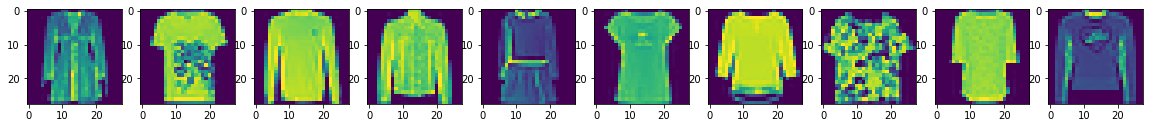

Class label: 2


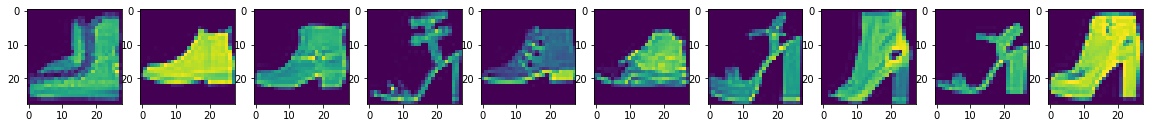

Class label: 3


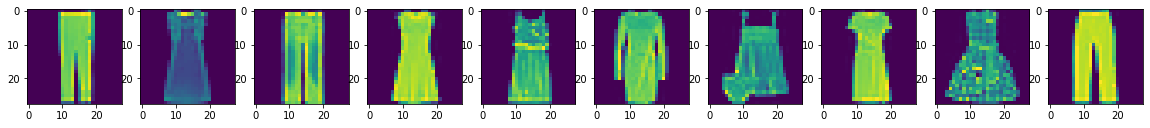

Class label: 4


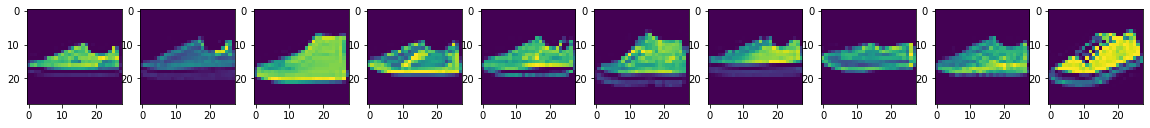

In [41]:
import random
testX_0=x_test[KMeansLabels==0]
testX_1=x_test[KMeansLabels==1]
testX_2=x_test[KMeansLabels==2]
testX_3=x_test[KMeansLabels==3]
testX_4=x_test[KMeansLabels==4]

for label_set, labels in zip ([testX_0, testX_1, 
                               testX_2, testX_3, testX_4],[0,1,2,3,4]):
    print("Class label: "+ str(labels))
    f, axarr = plt.subplots(1,10, figsize=(20,20))
    
    for j in range (0,10):
        index = random.randint(0, len(label_set))
        imgtest = label_set[index].reshape((28,28))
        axarr[j].imshow(imgtest)
    plt.show()


The plots above show us how the algorithm clustered 'similar' articles of clothing together. As per our interpretation, the labels are classified as below:

* Class 0: Bags

* Class 1: Tops (shirts/jackets etc)

* Class 2: Heeled Footwear

* Class 3: Dresses/Trousers

* Class 4: Flat Footwear (sneakers/sandals etc)

The algorithm used features like the general shapes of the items to cluster them together. For example, trousers and dresses were classified into one class, simply because their structure is more or less long and thin, which is a shape distinct from any of the other images. For the shoes, the flat and heeled type are seperated, because the algorithm used the presence of a protrusion (in the form of a heel) as a distinct feature. Bags are classified into their own class due to their distinct boxy shape, and there can be misclassifications there, like the one in our plot above, where a tshirt was classified as a bag. This is because of overlap in terms of their general shape being boxy.For the shirts, the distinguishing feature is the presence of sleeves, whether they be long or short.

In conclusion, as per our analysis, the mystery label is still defining a type of clothing as in the original MNIST Fashion Dataset, but it actually clumps together certain types due to their shapes, such as dresses and pants.

It is easy to verify our results though the K-Means Plot on TSNE Dimensions graph that was plotted earlier, through the following obersvations:

1. There is an overlap between the blue (class 0 - bags) and red (class 1 - tops), and that was expected because the feature of their general shapes are similar (boxy shape) - this was also mentioned in our analysis of the plotted images above. Another point to note is that the blue cluster (class 0 - bags) was split into two clumps, and our guess is that the bags with straps is seperated from the ones without straps (and that the one without straps is the one which overlaps with the tops)

2. There is an overlap at the boundary of the orange (class 2 - Heeled Footwear) and purple (class 4 - Flat Footwear) clusters. This is obvious as all shoes have similar features, except for the small extra heel part, which is why there is a bit of overlap between these clusters.

3. The yellow cluster (class 3 - dresses/trousers) is actually split into two clumps, and our guess is that one clump is for dresses, and the other for trousers. One of the two clumps overlaps with the red cluster (class 1 - tops) and our assumption is that it is the dresses part (since they have overlapping distinct features such as sleeves)

## References
1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
2. https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45
3. https://www.arxiv-vanity.com/papers/1712.02502/#:~:text=The%20role%20of%20striding%20has,they%20are%20still%20largely%20superficial.
4. https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/
5. https://adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/#:~:text=After%20we%20choose%20the%20filter,filter%20shifts%20is%20the%20stride.
6. https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27